In [212]:
from projectwind.LSTM_data import get_LSTM_data, WindowGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
train_df, val_df, test_df = get_LSTM_data(1)

/Users/hamzabenkirane/code/AmaurySALLES/projectwind/raw_data
1


In [214]:
len(train_df)

1

In [215]:
train_df[0]

,Power,Rotor Speed,Wind Speed,Blade Pitch,Wind_X,Wind_Y,Nacelle_X,Nacelle_Y,Day sin,Day cos
2019-05-05 00:00:00,1837.700000,12.867500,9.377500,-0.032600,-8.940538,2.829186,-0.974370,0.224951,-1.043217e-11,1.000000
2019-05-05 00:10:00,1813.160000,12.898800,9.433800,0.039100,-9.034049,2.717083,-0.974370,0.224951,4.361939e-02,0.999048
2019-05-05 00:20:00,1853.250000,12.967300,9.562700,-0.398700,-9.142769,2.802677,-0.974370,0.224951,8.715574e-02,0.996195
2019-05-05 00:30:00,1548.050000,12.461000,8.586500,-0.265200,-8.211298,2.510493,-0.982506,0.186233,1.305262e-01,0.991445
2019-05-05 00:40:00,1605.670000,12.695700,9.330000,-0.814000,-9.262709,1.118533,-0.994522,0.104528,1.736482e-01,0.984808
...,...,...,...,...,...,...,...,...,...,...
2021-01-09 23:10:00,20.206833,3.169950,4.083243,54.604615,-0.132511,-4.081093,-0.982833,-0.184499,-2.164396e-01,0.976296
2021-01-09 23:20:00,20.687417,3.237825,4.079912,53.900368,-0.191701,-4.075405,-0.982152,-0.188090,-1.736482e-01,0.984808
2021-01-09 23:30:00,21.168000,3.305700,4.076580,53.196120,-0.250754,-4.068861,-0.981458,-0.191678,-1.305262e-01,0.991445
2021-01-09 23:40:00,21.648583,3.373575,4.073248,52.491873,-0.309657,-4.061461,-0.980751,-0.195263,-8.715574e-02,0.996195


In [216]:
multi_window = WindowGenerator(720, 72, 72,
                 train_df[0], val_df[0], test_df[0],
                 label_columns=None)

In [217]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

    FeedBack.call = call

In [235]:
OUT_STEPS = 72
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)

        self.dense = tf.keras.layers.Dense(9)
        
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

            # predictions.shape => (time, batch, features)
            predictions = tf.stack(predictions)
            # predictions.shape => (batch, time, features)
            predictions = tf.transpose(predictions, [1, 0, 2])
        
        prediction = tf.keras.layers.Dense(self.out_steps)(predictions)
        
        return predictions

FeedBack.call = call

In [236]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features = 9)

In [237]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state
FeedBack.warmup = warmup

In [238]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [239]:

MAX_EPOCHS = 1000
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(multi_window.train, epochs=MAX_EPOCHS,
                      validation_data=multi_window.val,
                      callbacks=[early_stopping])
    return history

In [240]:
tf.keras.backend.clear_session()
history = compile_and_fit(feedback_model, multi_window)


#multi_val_performance = feedback_model.evaluate(multi_window.val)
#multi_performance = feedback_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(feedback_model)

Epoch 1/1000


ValueError: in user code:

    File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "feed_back" (type FeedBack).
    
    in user code:
    
        File "/var/folders/t8/d2f3pgzx5hs05rkp8c61zsbc0000gn/T/ipykernel_86186/3563926239.py", line 15, in call  *
            x, state = self.lstm_cell(x, states=state,
        File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/Users/hamzabenkirane/.pyenv/versions/3.8.12/envs/projectwind/lib/python3.8/site-packages/keras/backend.py", line 2223, in dot
            out = tf.matmul(x, y)
    
        ValueError: Exception encountered when calling layer "lstm_cell" (type LSTMCell).
        
        Dimensions must be equal, but are 9 and 10 for '{{node feed_back/lstm_cell/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](feed_back/dense/BiasAdd, feed_back/lstm_cell/MatMul/ReadVariableOp)' with input shapes: [?,9], [10,128].
        
        Call arguments received:
          • inputs=tf.Tensor(shape=(None, 9), dtype=float32)
          • states=['tf.Tensor(shape=(None, 32), dtype=float32)', 'tf.Tensor(shape=(None, 32), dtype=float32)']
          • training=True
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 720, 10), dtype=float32)
      • training=True


In [ ]:
X_test = multi_window.test[0]
y_test = multi_window.test[1]

In [120]:
import pandas as pd
pd.DataFrame(feedback_model.predict(X_test)[0])

,0,1,2,3,4,5,6,7,8
0,9.660961,10.388817,9.346885,10.335327,10.615832,8.258314,9.926704,9.018428,8.850881
1,13.670663,14.154629,13.532795,14.250996,13.907906,12.442825,14.657093,13.128471,13.147601
2,14.796450,15.061865,14.793338,15.311180,14.836436,13.199105,15.708654,14.112535,14.074497
3,15.780719,15.759474,15.735257,16.018496,15.344068,13.825414,16.240368,15.074380,14.610158
4,16.002857,15.916500,15.948691,16.178082,15.458791,13.966335,16.361683,15.290380,14.732136
...,...,...,...,...,...,...,...,...,...
67,16.088053,15.977055,16.031158,16.239859,15.503991,14.020346,16.409481,15.372882,14.779804
68,16.088053,15.977055,16.031158,16.239859,15.503991,14.020346,16.409481,15.372882,14.779804
69,16.088053,15.977055,16.031158,16.239859,15.503991,14.020346,16.409483,15.372882,14.779804
70,16.088053,15.977055,16.031158,16.239859,15.503991,14.020346,16.409483,15.372882,14.779804


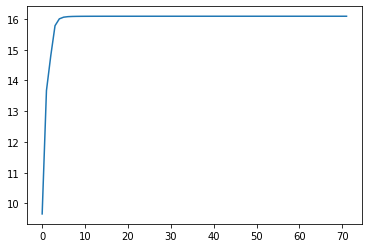

In [116]:
plt.plot(pd.DataFrame(feedback_model.predict(X_test)[0])[0])

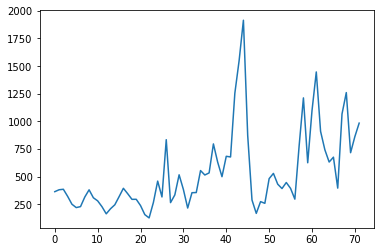

In [124]:
plt.plot(pd.DataFrame(y_test[0]))